# Update to hail proxy of Raupach et al 2023

In [1]:
%cd git/future_hail_global/

/home/561/tr2908/git/future_hail_global


In [3]:
import sys
sys.path.append('../aus400_hail/')
sys.path.append('../xarray_parcel/')

import dask
import json
import warnings
import numpy as np
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
import modules.hail_sounding_functions as hs
import modules.updated_proxy as updated_proxy
from dask.distributed import Client, LocalCluster

# Allow large chunks.
_ = dask.config.set(**{'array.slicing.split_large_chunks': False})

## Settings

In [4]:
plt.rcParams['figure.figsize'] = (13,5)                                   # Fig. size for non-facet plots.
plt.rcParams['font.size'] = 12                                            # Font size for plots.
plt.rcParams['axes.formatter.useoffset'] = False                          # Don't use offsets in plots.
results_dir = 'results/'                                                  # Results directory.
era5_hail_cache = '~/git/aus400_hail/data/era5_hail_profiles.nc'          # ERA5 cache file for hail.
era5_storm_cache = '~/git/aus400_hail/data/era5_storm_profiles.nc'        # ERA5 cache file for other storms.
era5_nostorm_cache = '~/git/aus400_hail/data/era5_non_storm_profiles.nc'  # ERA5 cache file for no-storm cases.
lookup_dir = '/g/data/w42/tr2908/aus400_hail/'                            # Moist-adiabat lookup cache directory. 
proxy_results_file = '../aus400_hail/results/results_era5.json'           # Trained proxy definition file. 
proxy_conds_file = '~/git/aus400_hail/results/era5_proxy_extra_conds.csv' # Extra proxy conditions file.
warnings.filterwarnings("ignore", category=FutureWarning)                 # Ignore FutureWarnings (in Dask).

Initiatiate parcel function, and start a dask cluster for processing; either local (to use just this node) or off-node (for large processing jobs). For info on how to start local or off-node dask clusters, see [this page](https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD). To see distributed job status, use `squeue` on the VDI machine this job is running on.

In [5]:
client = Client()
print(client)

<Client: 'tcp://127.0.0.1:37971' processes=7 threads=28, memory=125.18 GiB>


Open the original proxy values.

In [6]:
with open(proxy_results_file, 'r') as f:
    era5_results = json.load(f)
extra_conditions = pd.read_csv(proxy_conds_file)
band_var = era5_results['band_variable']

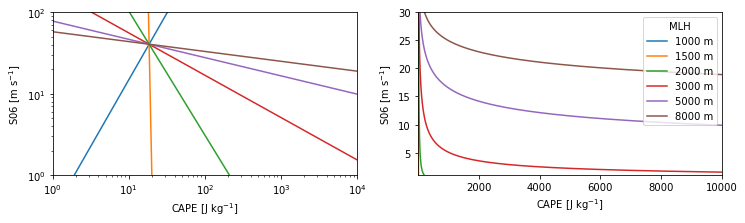

In [12]:
reload(updated_proxy)
updated_proxy.plot_proxy_discrims(era5_results=era5_results, file='results/supplementary/proxy_by_MLH.pdf')

When the melting level height is below about 2000 m, the discriminator line in log-log space is close to vertical meaning that only CAPE matters and shear is not required. Below about 1500 m the slope of the line is negated and in this case high CAPE, low shear is considered more hail prone than high CAPE, low CAPE, high shear. 

We make a simple change so that below 2000 m, the proxy is fixed at the discriminator for 2000 m.

Load era5 data using cached version from proxy training.

In [ ]:
hail_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_hail_cache)
storm_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_storm_cache)
nostorm_profiles = hs.read_era5_profiles(coords=None, cache_file=era5_nostorm_cache)

In [ ]:
%%capture 
# Using %%capture to discard long output.
conv_hail = hs.profile_properties(profiles=hail_profiles).to_dataframe()
conv_storm = hs.profile_properties(profiles=storm_profiles).to_dataframe()
conv_nostorm = hs.profile_properties(profiles=nostorm_profiles).to_dataframe()

# Remove duplicated storms.
conv_hail = conv_hail[~conv_hail.duplicated()]
conv_storm = conv_storm[~conv_storm.duplicated()]
conv_nostorm = conv_nostorm[~conv_nostorm.duplicated()]

In [ ]:
conv_hail['true_hail'] = True
conv_storm['true_hail'] = False
conv_nostorm['true_hail'] = False
d = pd.concat([conv_hail, conv_storm, conv_nostorm])

In [ ]:
reload(updated_proxy)

In [ ]:
d['new_proxy'] = updated_proxy.apply_proxy(dat=d, band_var=band_var, 
                                           alpha_a = era5_results['hail_alpha_a'],
                                           alpha_b = era5_results['hail_alpha_b'], 
                                           beta_a = era5_results['hail_beta_a'], 
                                           beta_b = era5_results['hail_beta_b'],
                                           band_limits=[2000, None])

In [ ]:
d['old_proxy'] = updated_proxy.apply_proxy(dat=d, band_var=band_var, 
                                           alpha_a = era5_results['hail_alpha_a'],
                                           alpha_b = era5_results['hail_alpha_b'], 
                                           beta_a = era5_results['hail_beta_a'], 
                                           beta_b = era5_results['hail_beta_b'],
                                           band_limits=None)

Original "extra condition" thresholds from Raupach et al., 2023 were:

```
Threshold of lapse_rate_700_500 < -5.45 will remove ~2.5% of good (Hail) points but ~13.0% of bad points.
Threshold of mixed_100_lifted_index < 0.4 will remove ~2.5% of good (Hail) points but ~10.0% of bad points.
Threshold of temp_500 < 265.46 will remove ~2.5% of good (Hail) points but ~9.0% of bad points.
```

In [ ]:
updated_proxy.prox_performance(dat=d.copy(), proxy='old_proxy', extra_conditions=extra_conditions)

In [ ]:
updated_proxy.prox_performance(dat=d.copy(), proxy='new_proxy', extra_conditions=extra_conditions)